## Device check

In [1]:
!nvidia-smi

Mon Oct 30 11:00:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   27C    P0    40W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Packages

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

In [3]:

import lightning.pytorch as pl
from lightning.pytorch import Trainer, seed_everything

import logging
logging.basicConfig(level="INFO")

import math
from matplotlib import pyplot

import numpy as np

import os

import pandas as pd
from pprint import pprint

import sys
sys.path.append("../src")

import timm
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
%load_ext autoreload
%autoreload 2

In [5]:
import config
from dataloader import BEDataset, BEDataModule
import token_learner
from transformer import PositionalEncoder, SelfAttentionHead, MultiHeadSelfAttention, FeedFowardLayer, LayerNormalization, TransformerDecoderLayer, TransformerDecoder, generate_causal_attention_mask

from film_layers import FiLMBlockV2, FiLMEncoder, ResBlockDWConv
from rt1 import RT1Encoder, RT1Decoder, ActionGenerator
from utils.data_utils import History
from utils.model_utils import TextEncoder, ImageFeatureExtractor, plot_attention


## Data Module

In [6]:
dm = BEDataModule()
dm.setup()

INFO:root:Training on 3964 samples.
INFO:root:Validating on 912 samples.
INFO:root:Testing on 250 samples.


Total # examples: 5126


## Fetch batch

In [7]:
sample = next(iter(dm.test_dataloader()))
print(sample.keys())
sample["in_state"].shape

dict_keys(['sample_id', 'in_state', 'action_desc', 'source_mask'])


torch.Size([4, 3, 288, 288])

In [8]:
%%time
sample = next(iter(dm.train_dataloader()))
print(sample.keys())
sample["in_state"].shape

dict_keys(['sample_id', 'in_state', 'action_desc', 'source_mask', 'motor_cmd', 'target_mask'])
CPU times: user 1.11 s, sys: 906 ms, total: 2.02 s
Wall time: 4.73 s


torch.Size([4, 3, 288, 288])

In [9]:
sample["source_mask"].shape, sample["target_mask"].shape

(torch.Size([4, 1, 48]), torch.Size([4, 1, 16, 16]))

In [10]:
sample["motor_cmd"]["labels"]

tensor([[25, 46, 39, 15, 46, 36, 25, 44, 15,  2,  0,  0,  0,  0,  0,  0],
        [ 5, 41, 39,  9, 41, 36,  5, 44,  9,  2,  0,  0,  0,  0,  0,  0],
        [17, 46, 30, 13, 41, 36, 17, 48, 13,  2,  0,  0,  0,  0,  0,  0],
        [23, 31, 39,  9, 46, 34, 23, 43,  9,  2,  0,  0,  0,  0,  0,  0]])

## Model Design

<!-- ![RT1 model architecture](../../imgs/rt1+.png) -->
<center>
    <img src="../imgs/rt1+.png" alt="RT1 model architecture" width="300" height="400">

<center>

### Encoder

#### Test Text Encoder

In [110]:
# te = TextEncoder(freeze=True).cuda()
# summary(model=te, col_names=["num_params", "trainable"])

In [109]:
# emb = te(
#     inp_ids=sample["action_desc"]["ids"].cuda(),
#     mask=sample["action_desc"]["mask"].cuda(),
#     tok_type_ids=sample["action_desc"]["token_type_ids"].cuda()
# )

# emb.shape

torch.Size([4, 512])

#### Test Img Feature Extractor

In [ ]:
# fe = ImageFeatureExtractor(pretrained=True, arch="efficientnet_b3").cuda()

# summary(fe, col_names=["num_params", "trainable"])

In [ ]:
# img_ftrs = fe(sample["in_state"].cuda())

# img_ftrs.shape

#### Test FiLM Block

In [16]:
# film_block = FiLMBlockV2().cuda()
# print(film_block)
# summary(model=film_block)

In [17]:
# text_cond_ftrs = film_block(
#     img_features=img_ftrs, 
#     conditioning=emb
# )

# text_cond_ftrs.shape

#### Test Residual FiLM Block

In [18]:
# dw_res = ResBlockDWConv(512, 512).cuda()
# summary(model=dw_res)

In [19]:
# text_cond_ftrs_res = dw_res(
#     img_features=img_ftrs, 
#     conditioning=emb
# )

# text_cond_ftrs_res.shape

#### Test FiLM Encoder

In [20]:
# film_encoder = FiLMEncoder(
#     arch="resnet34",
#     n_res_blocks=6,
# ).cuda()

# # print(film_encoder)
# summary(model=film_encoder)

In [21]:
# %%time

# out = film_encoder(
#     x= sample["in_state"].cuda(),
#     conditioning= emb
# )

# out.shape

#### Token Learner

In [22]:
# N, C, H_W = out.shape
# N, C, H_W

In [23]:
# tokL_v11 = token_learner.TokenLearnerModuleV11(feature_shape=(N, H_W, C)).cuda()
# print(tokL_v11)
# summary(model=tokL_v11)

In [24]:
# learned_tokens = tokL_v11(out.view(N, H_W, C))
# learned_tokens.shape

In [154]:
tokenized_inputs = torch.empty((B, config.NUM_HISTORY+1, config.D_MODEL, config.NUM_LEARNED_TOKENS))
tokenized_inputs.shape

torch.Size([8, 6, 512, 8])

#### RT-1 Encoder

In [11]:
encoder = RT1Encoder(
    cnn_bacnbone="efficientnet_b3", 
    num_res_blocks=6, 
    freeze_cnn_backbone=True
).to(config.DEVICE)

summary(model=encoder, col_names=["num_params", "trainable"])

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b3.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnet_b3.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Layer (type:depth-idx)                                       Param #                   Trainable
RT1Encoder                                                   --                        Partial
├─TextEncoder: 1-1                                           --                        False
│    └─BertModel: 2-1                                        --                        False
│    │    └─BertEmbeddings: 3-1                              (15,891,456)              False
│    │    └─BertEncoder: 3-2                                 (12,609,536)              False
│    │    └─BertPooler: 3-3                                  (262,656)                 False
│    └─Dropout: 2-2                                          --                        --
├─FiLMEncoder: 1-2                                           --                        Partial
│    └─ImageFeatureExtractor: 2-3                            --                        Partial
│    │    └─EfficientNetFeatures: 3-4                        (1

In [12]:
%%time 

src_enc, tokens = encoder._encode(
    input_ids=sample["action_desc"]["ids"].cuda(),
    attn_mask=sample["action_desc"]["mask"].cuda(),
    token_type_ids=sample["action_desc"]["token_type_ids"].cuda(),
    imgs=sample["in_state"].cuda()
)

src_enc.shape, tokens.shape

CPU times: user 1.01 s, sys: 974 ms, total: 1.98 s
Wall time: 13.5 s


(torch.Size([4, 512]), torch.Size([4, 512, 8]))

In [13]:
%%time

src_enc, learned_tokens = encoder(
    input_ids=sample["action_desc"]["ids"].cuda(),
    attn_mask=sample["action_desc"]["mask"].cuda(),
    token_type_ids=sample["action_desc"]["token_type_ids"].cuda(),
    imgs=sample["in_state"].cuda()
)

learned_tokens.shape, learned_tokens.device

CPU times: user 197 ms, sys: 50.7 ms, total: 248 ms
Wall time: 1.23 s


(torch.Size([4, 48, 512]), device(type='cuda', index=0))

### Decoder

In [14]:
inp_embedding = encoder.text_encoder.encoder.embeddings

target_embedding = nn.Embedding(
    num_embeddings=config.TARGET_VOCAB_SIZE, 
    embedding_dim=config.EMBEDDING_DIM, 
    padding_idx=config.TGT_PAD_TOK_ID
).cuda()

In [15]:
inp = sample["action_desc"]["ids"].cuda()
outp = sample["motor_cmd"]["decoder_inp_ids"].cuda()

inp_emb = inp_embedding(inp)
outp_emb = target_embedding(outp)

inp_emb.shape, outp_emb.shape

(torch.Size([4, 16, 512]), torch.Size([4, 16, 512]))

#### Test MultiHead Self-Attention Layer

In [248]:
# sa = SelfAttentionHead().cuda()
# sa.eval()
# print(sa)
# summary(sa)

In [298]:
# %%time

# mem, attn_w = sa(
#     q=inp_emb, 
#     k=inp_emb, 
#     v=inp_emb, 
#     mask=sample["target_mask"].cuda(),
#     return_weights=True
# )

# mem.shape, attn_w.shape

CPU times: user 2.38 ms, sys: 5 ms, total: 7.38 ms
Wall time: 209 ms


(torch.Size([4, 16, 512]), torch.Size([4, 16, 16]))

In [250]:
# plot_attention(attn_w)

In [251]:
mhsa = MultiHeadSelfAttention(num_heads=4).cuda()
mhsa.eval()
print(mhsa)
summary(mhsa)

MultiHeadSelfAttention(
  (attention_heads): ModuleList(
    (0-3): 4 x SelfAttentionHead(
      (dropout): Dropout(p=0.1, inplace=False)
      (_softmax): Softmax(dim=-1)
      (w_q): Linear(in_features=512, out_features=512, bias=False)
      (w_k): Linear(in_features=512, out_features=512, bias=False)
      (w_v): Linear(in_features=512, out_features=512, bias=False)
    )
  )
  (output_layer): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=False)
    (1): Dropout(p=0.1, inplace=False)
  )
)


Layer (type:depth-idx)                   Param #
MultiHeadSelfAttention                   --
├─ModuleList: 1-1                        --
│    └─SelfAttentionHead: 2-1            --
│    │    └─Dropout: 3-1                 --
│    │    └─Softmax: 3-2                 --
│    │    └─Linear: 3-3                  262,144
│    │    └─Linear: 3-4                  262,144
│    │    └─Linear: 3-5                  262,144
│    └─SelfAttentionHead: 2-2            --
│    │    └─Dropout: 3-6                 --
│    │    └─Softmax: 3-7                 --
│    │    └─Linear: 3-8                  262,144
│    │    └─Linear: 3-9                  262,144
│    │    └─Linear: 3-10                 262,144
│    └─SelfAttentionHead: 2-3            --
│    │    └─Dropout: 3-11                --
│    │    └─Softmax: 3-12                --
│    │    └─Linear: 3-13                 262,144
│    │    └─Linear: 3-14                 262,144
│    │    └─Linear: 3-15                 262,144
│    └─SelfAttentionHead: 

In [279]:
%%time

mem, attn_w = mhsa(
    q=inp_emb, 
    k=inp_emb, 
    v=inp_emb, 
    mask=sample["target_mask"].cuda(),
    return_weights=True
)

mem.shape, attn_w.shape

CPU times: user 2.73 ms, sys: 79 µs, total: 2.81 ms
Wall time: 2.28 ms


(torch.Size([4, 16, 512]), torch.Size([4, 4, 16, 16]))

In [280]:
attn_w[0, 0, 0]

tensor([0.0606, 0.0543, 0.0559, 0.0649, 0.0481, 0.0547, 0.0406, 0.0551, 0.0659,
        0.0666, 0.0759, 0.0744, 0.0740, 0.0715, 0.0697, 0.0679],
       device='cuda:0', grad_fn=<SelectBackward0>)

#### Plot Self-attention weights

In [16]:
# plot_attention(attn_w)
# plot_attention(attn_w, example_idx=2)

#### Test Cross Attention Layer

In [282]:
# num_heads = 2

# cross_attention = MultiHeadSelfAttention(
#     num_heads=num_heads
# ).cuda()

# cross_attention.eval()
# print(cross_attention)
# summary(cross_attention)

MultiHeadSelfAttention(
  (attention_heads): ModuleList(
    (0-1): 2 x SelfAttentionHead(
      (dropout): Dropout(p=0.1, inplace=False)
      (_softmax): Softmax(dim=-1)
      (w_q): Linear(in_features=512, out_features=512, bias=False)
      (w_k): Linear(in_features=512, out_features=512, bias=False)
      (w_v): Linear(in_features=512, out_features=512, bias=False)
    )
  )
  (output_layer): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=False)
    (1): Dropout(p=0.1, inplace=False)
  )
)


Layer (type:depth-idx)                   Param #
MultiHeadSelfAttention                   --
├─ModuleList: 1-1                        --
│    └─SelfAttentionHead: 2-1            --
│    │    └─Dropout: 3-1                 --
│    │    └─Softmax: 3-2                 --
│    │    └─Linear: 3-3                  262,144
│    │    └─Linear: 3-4                  262,144
│    │    └─Linear: 3-5                  262,144
│    └─SelfAttentionHead: 2-2            --
│    │    └─Dropout: 3-6                 --
│    │    └─Softmax: 3-7                 --
│    │    └─Linear: 3-8                  262,144
│    │    └─Linear: 3-9                  262,144
│    │    └─Linear: 3-10                 262,144
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       524,288
│    └─Dropout: 2-4                      --
Total params: 2,097,152
Trainable params: 2,097,152
Non-trainable params: 0

In [283]:
%%time

cross_attn_mem, cross_attn_w = cross_attention(
    q=inp_emb, 
    k=learned_tokens, 
    v=learned_tokens, 
    mask=sample["source_mask"].cuda(),
    return_weights=True
)

cross_attn_mem.shape, cross_attn_w.shape

CPU times: user 793 µs, sys: 864 µs, total: 1.66 ms
Wall time: 1.33 ms


(torch.Size([4, 16, 512]), torch.Size([4, 2, 16, 48]))

#### Plot Cross attention weights

In [17]:
# plot_attention(cross_attn_w)
# plot_attention(cross_attn_w, example_idx=2)

#### Test Transformer decoder layer

In [18]:
# dec_layer = TransformerDecoderLayer().cuda()
# print(dec_layer)
# dec_layer.eval()
# summary(dec_layer)

In [20]:
# dec_out, self_attn_w, cross_attn_w = dec_layer(
#     inp=inp_emb, 
#     encoder_out=learned_tokens, 
#     src_mask=sample["source_mask"].cuda(), 
#     target_mask=sample["target_mask"].cuda(), 
#     debug=False
# )
# dec_out.shape, self_attn_w.shape, cross_attn_w.shape

In [19]:
# plot_attention(self_attn_w)
# plot_attention(cross_attn_w)

#### Test Transformer decoder

In [49]:
dec = TransformerDecoder(num_layers=1).cuda()
print(dec)
dec.eval()
summary(model=dec)

TransformerDecoder(
  (layers): ModuleList(
    (0): TransformerDecoderLayer(
      (self_attn): MultiHeadSelfAttention(
        (attention_heads): ModuleList(
          (0-3): 4 x SelfAttentionHead(
            (dropout): Dropout(p=0.15, inplace=False)
            (_softmax): Softmax(dim=-1)
            (w_q): Linear(in_features=512, out_features=512, bias=False)
            (w_k): Linear(in_features=512, out_features=512, bias=False)
            (w_v): Linear(in_features=512, out_features=512, bias=False)
          )
        )
        (output_layer): Sequential(
          (0): Linear(in_features=2048, out_features=512, bias=False)
          (1): Dropout(p=0.15, inplace=False)
        )
      )
      (cross_attn): MultiHeadSelfAttention(
        (attention_heads): ModuleList(
          (0-3): 4 x SelfAttentionHead(
            (dropout): Dropout(p=0.15, inplace=False)
            (_softmax): Softmax(dim=-1)
            (w_q): Linear(in_features=512, out_features=512, bias=False)
     

Layer (type:depth-idx)                             Param #
TransformerDecoder                                 --
├─ModuleList: 1-1                                  --
│    └─TransformerDecoderLayer: 2-1                --
│    │    └─MultiHeadSelfAttention: 3-1            4,194,304
│    │    └─MultiHeadSelfAttention: 3-2            4,194,304
│    │    └─LayerNormalization: 3-3                1,024
│    │    └─LayerNormalization: 3-4                1,024
│    │    └─Sequential: 3-5                        2,099,712
│    │    └─LayerNorm: 3-6                         1,024
│    │    └─Dropout: 3-7                           --
Total params: 10,491,392
Trainable params: 10,491,392
Non-trainable params: 0

#### Test Transformer Decoder

In [50]:
dec_out, self_attn_ws, cross_attn_ws = dec(
    inp=inp_emb, 
    encoder_out=learned_tokens, 
    src_mask=sample["source_mask"].cuda(), 
    target_mask=sample["target_mask"].cuda(), 
    debug=False
)

dec_out.shape, self_attn_ws.shape, cross_attn_ws.shape

(torch.Size([4, 16, 512]),
 torch.Size([4, 4, 16, 16]),
 torch.Size([4, 4, 16, 48]))

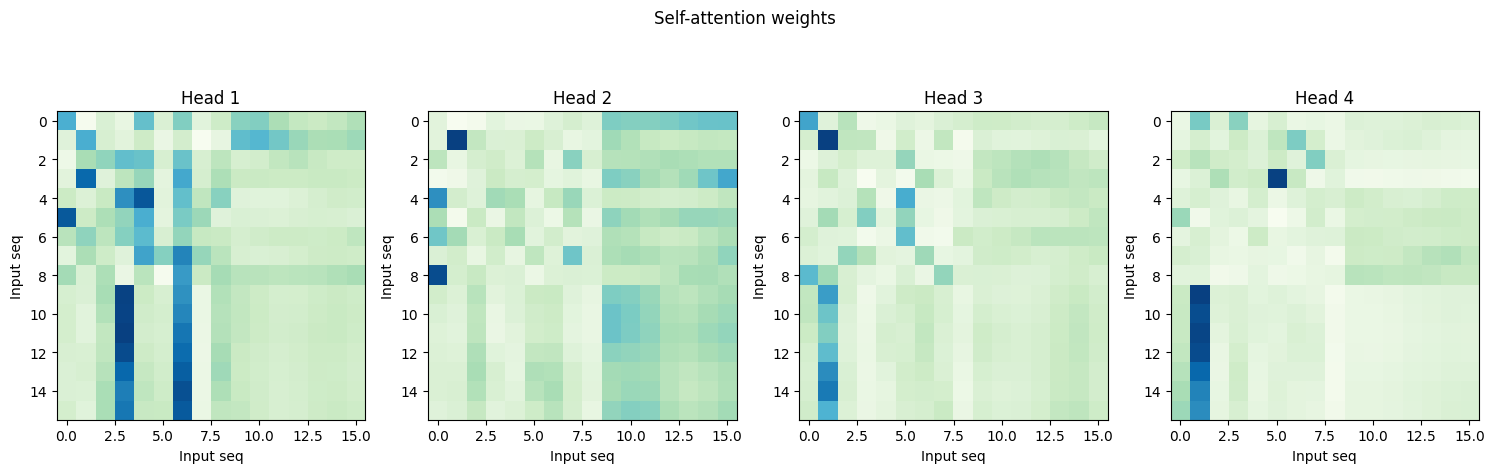

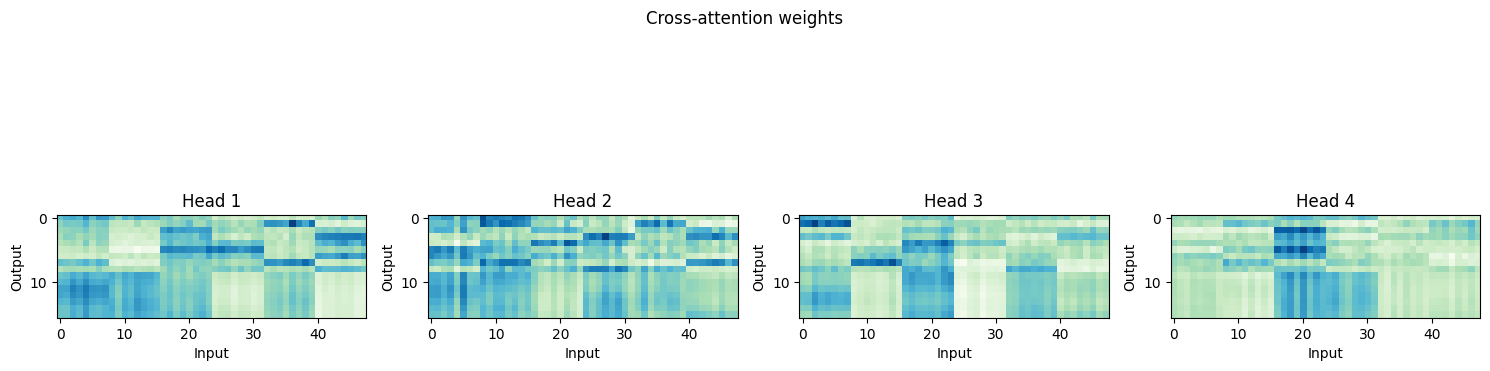

In [51]:
plot_attention(self_attn_ws)
plot_attention(cross_attn_ws)

#### Action Generator

In [390]:
generator = ActionGenerator().cuda()
print(generator)
summary(generator)

ActionGenerator(
  (proj): Sequential(
    (0): Linear(in_features=512, out_features=52, bias=True)
    (1): Dropout(p=0.15, inplace=False)
  )
  (_softmax): LogSoftmax(dim=-1)
)


Layer (type:depth-idx)                   Param #
ActionGenerator                          --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       26,676
│    └─Dropout: 2-2                      --
├─LogSoftmax: 1-2                        --
Total params: 26,676
Trainable params: 26,676
Non-trainable params: 0

In [392]:
preds = generator(dec_out)
preds.shape

torch.Size([4, 16, 52])

In [393]:
predicted_next_tok = preds[:, -1, :].argmax(dim=-1)
predicted_next_tok.shape, predicted_next_tok

(torch.Size([4]), tensor([5, 5, 5, 5], device='cuda:0'))

### RT-1 Decoder

In [54]:
decoder = RT1Decoder(num_decoder_layers=1).cuda()
print(decoder)
decoder.eval()
summary(model=decoder)

RT1Decoder(
  (target_embedding): Embedding(52, 512)
  (token_embedding): Linear(in_features=512, out_features=512, bias=False)
  (pos_embedding): PositionalEncoder()
  (transformer): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiHeadSelfAttention(
          (attention_heads): ModuleList(
            (0-3): 4 x SelfAttentionHead(
              (dropout): Dropout(p=0.15, inplace=False)
              (_softmax): Softmax(dim=-1)
              (w_q): Linear(in_features=512, out_features=512, bias=False)
              (w_k): Linear(in_features=512, out_features=512, bias=False)
              (w_v): Linear(in_features=512, out_features=512, bias=False)
            )
          )
          (output_layer): Sequential(
            (0): Linear(in_features=2048, out_features=512, bias=False)
            (1): Dropout(p=0.15, inplace=False)
          )
        )
        (cross_attn): MultiHeadSelfAttention(
          (attention_heads): Mo

Layer (type:depth-idx)                                  Param #
RT1Decoder                                              --
├─Embedding: 1-1                                        26,624
├─Linear: 1-2                                           262,144
├─PositionalEncoder: 1-3                                --
├─TransformerDecoder: 1-4                               --
│    └─ModuleList: 2-1                                  --
│    │    └─TransformerDecoderLayer: 3-1                10,491,392
├─LayerNormalization: 1-5                               --
│    └─LayerNorm: 2-2                                   1,024
├─ActionGenerator: 1-6                                  --
│    └─Sequential: 2-3                                  --
│    │    └─Linear: 3-2                                 26,676
│    │    └─Dropout: 3-3                                --
│    └─LogSoftmax: 2-4                                  --
Total params: 10,807,860
Trainable params: 10,807,860
Non-trainable params: 0

In [55]:
%time

preds, self_attn_ws, cross_attn_ws = decoder(
    inp=sample["motor_cmd"]["decoder_inp_ids"].cuda(), 
    encoder_out=learned_tokens, 
    src_mask=sample["source_mask"].cuda(), 
    target_mask=sample["target_mask"].cuda(), 
    debug=False
)

preds.shape, self_attn_ws.shape, cross_attn_ws.shape

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.58 µs


(torch.Size([4, 16, 52]),
 torch.Size([4, 4, 16, 16]),
 torch.Size([4, 4, 16, 48]))

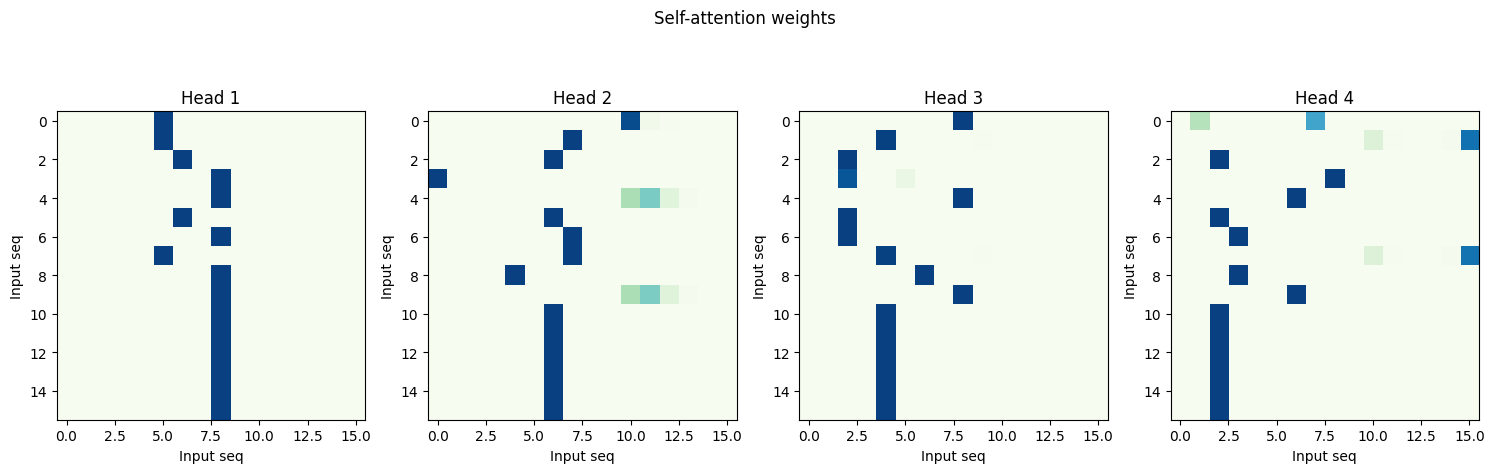

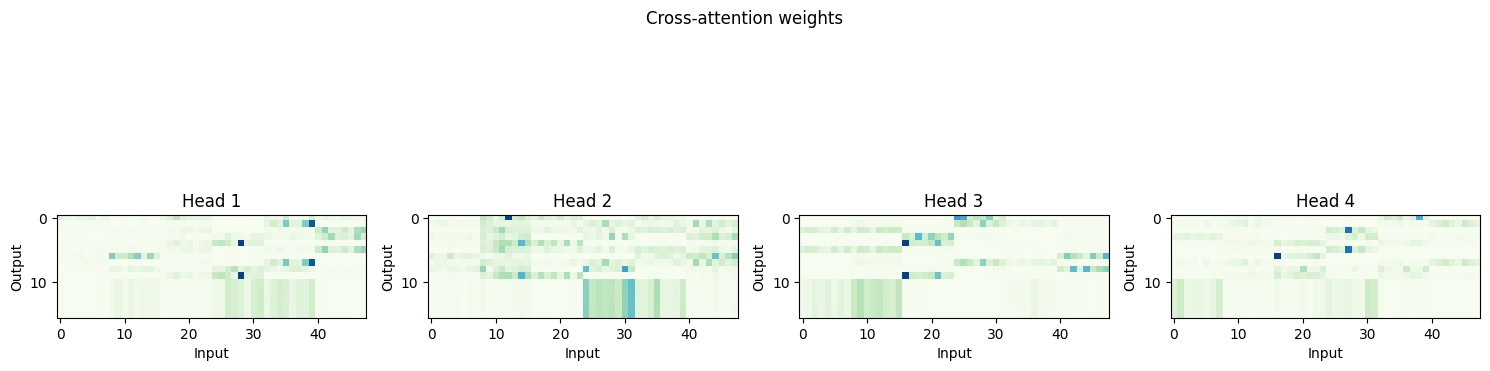

In [56]:
plot_attention(self_attn_ws)
plot_attention(cross_attn_ws)

### RT-1 

In [73]:
class RT1(pl.LightningModule):
    def __init__(
        self
    ):
        super().__init__()
        self.encoder = RT1Encoder()
        self.decoder = RT1Decoder()
        self.loss_fn = nn.CrossEntropyLoss(
            ignore_index=config.TGT_PAD_TOK_ID, 
            label_smoothing=config.LABEL_SMOOTHING
        )
        
    def forward(
        self, 
        input_ids:torch.tensor, 
        attn_mask:torch.tensor, 
        token_type_ids:torch.tensor, 
        imgs:torch.tensor,
        decoder_inp:torch.tensor,
        src_mask:torch.tensor,
        target_mask:torch.tensor
    ):
        
        _, learned_tokens = self.encoder(
            input_ids=input_ids, 
            attn_mask=attn_mask, 
            token_type_ids=token_type_ids, 
            imgs=imgs
        )
        
        return self.decoder(
            inp=decoder_inp, 
            encoder_out=learned_tokens, 
            src_mask=src_mask, 
            target_mask=target_mask 
        )
    
    def configure_optimizers(self):
        opt = getattr(torch.optim, config.OPTIMIZER)(
            params=[p for p in self.parameters() if p.requires_grad], 
            lr=config.LR
        )
        return opt
    
    def training_step(self, batch, batch_idx):
        
        input_ids=batch["action_desc"]["ids"]
        attn_mask=batch["action_desc"]["mask"]
        token_type_ids=batch["action_desc"]["token_type_ids"]
        imgs=batch["in_state"]
        decoder_inp=batch["motor_cmd"]["decoder_inp_ids"] 
        src_mask=batch["source_mask"] 
        target_mask=batch["target_mask"] 
        
        # forward pass
        preds, self_attn_ws, cross_attn_ws = self(
                                                input_ids=input_ids, 
                                                attn_mask=attn_mask, 
                                                token_type_ids=token_type_ids, 
                                                imgs=imgs,
                                                decoder_inp=decoder_inp, 
                                                src_mask=src_mask, 
                                                target_mask=target_mask 
                                            )
        
        # compute loss
        labels = batch["motor_cmd"]["labels"]
        train_loss = self.loss_fn(preds.view(-1, preds.shape[2]), labels.view(-1))
        # return loss
        metrics = {"loss": train_loss}
        self.log_dict(metrics, prog_bar=True, logger=None, on_step=True, on_epoch=True)
        
        return metrics
    
    def validation_step(self, batch, batch_idx):
        
        input_ids=batch["action_desc"]["ids"]
        attn_mask=batch["action_desc"]["mask"]
        token_type_ids=batch["action_desc"]["token_type_ids"]
        imgs=batch["in_state"]
        decoder_inp=batch["motor_cmd"]["decoder_inp_ids"] 
        src_mask=batch["source_mask"] 
        target_mask=batch["target_mask"] 
        
        # forward pass
        preds, self_attn_ws, cross_attn_ws = self(
                                                input_ids=input_ids, 
                                                attn_mask=attn_mask, 
                                                token_type_ids=token_type_ids, 
                                                imgs=imgs,
                                                decoder_inp=decoder_inp, 
                                                src_mask=src_mask, 
                                                target_mask=target_mask 
                                            )
        
        # compute loss
        labels = batch["motor_cmd"]["labels"]
        val_loss = self.loss_fn(preds.view(-1, preds.shape[2]), labels.view(-1))
        # return loss
        metrics = {"loss": val_loss}
        self.log_dict(metrics, prog_bar=False, logger=None, on_step=False, on_epoch=True)
        
        return metrics
    
    def test_step(self, batch, batch_idx):
        pass
    

## Training

In [74]:
seed_everything(config.SEED)

[rank: 0] Seed set to 1234


1234

In [75]:
rt1 = RT1()
print(rt1)

summary(model=rt1)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b3.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnet_b3.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


RT1(
  (encoder): RT1Encoder(
    (text_encoder): TextEncoder(
      (encoder): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 512, padding_idx=0)
          (position_embeddings): Embedding(512, 512)
          (token_type_embeddings): Embedding(2, 512)
          (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-3): 4 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=512, out_features=512, bias=True)
                  (key): Linear(in_features=512, out_features=512, bias=True)
                  (value): Linear(in_features=512, out_features=512, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (output): BertSelfOutput(
                  (den

Layer (type:depth-idx)                                            Param #
RT1                                                               --
├─RT1Encoder: 1-1                                                 --
│    └─TextEncoder: 2-1                                           --
│    │    └─BertModel: 3-1                                        (28,763,648)
│    │    └─Dropout: 3-2                                          --
│    └─FiLMEncoder: 2-2                                           --
│    │    └─ImageFeatureExtractor: 3-3                            10,300,456
│    │    └─ModuleList: 3-4                                       5,283,840
│    └─TokenLearnerModuleV11: 2-3                                 --
│    │    └─LayerNormalization: 3-5                               1,024
│    │    └─FeedFowardLayer: 3-6                                  66,696
├─RT1Decoder: 1-2                                                 --
│    └─Embedding: 2-4                                             

In [ ]:
trainer = Trainer(
    # deterministic=True, 
    min_epochs=2, 
    max_epochs=config.EPOCHS, 
    gradient_clip_val=config.GRAD_CLIP_VAL, 
    # fast_dev_run=True
)

dm = BEDataModule()
trainer.fit(model=rt1, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:Training on 3613 samples.
INFO:root:Validating on 895 samples.
INFO:root:Testing on 250 samples.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | encoder | RT1Encoder       | 44.4 M
1 | decoder | RT1Decoder       | 10.8 M
2 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
16.4 M    Trainable params
38.9 M    Non-trainable params
55.2 M    Total params
220.894   Total estimated model params size (MB)


Total # examples: 4758
Epoch 0:  74%|███████▍  | 333/451 [01:53<00:40,  2.94it/s, v_num=11, loss_step=2.560]

In [65]:
!nvidia-smi

Mon Oct 30 11:40:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   29C    P0    54W / 300W |   1605MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------